In [5]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', 1)
import re 
import string
import os
import emoji
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=2.0)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

In [2]:
df = pd.read_csv('Tweets.csv')
df = df.reindex(np.random.permutation(df.index))
print(df.columns)

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'name', 'retweet_count',
       'text', 'tweet_coord', 'tweet_created', 'tweet_location',
       'user_timezone'],
      dtype='object')


In [3]:
df = df[['text','airline_sentiment']]

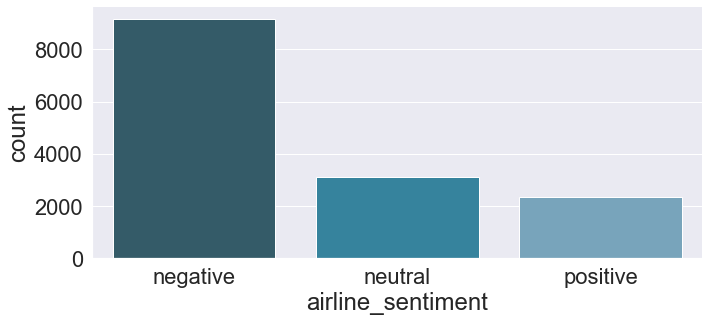

In [6]:
sns.factorplot(x="airline_sentiment", data=df, kind="count", size=5, aspect=2.0, palette="PuBuGn_d")
plt.show()

In [16]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        #We will replace the emoji symbols with a description, which makes using a regex for counting easier
       # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df
tc = TextCounts()
df_eda = tc.fit_transform(df.text)
df_eda['airline_sentiment'] = df.airline_sentiment


In [17]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('airline_sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='airline_sentiment', size=5, hue='airline_sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()



Descriptive stats for count_words
---------------------------------
                    count       mean       std  min   25%   50%   75%   max
airline_sentiment                                                          
negative           9178.0  20.387557  6.100020  2.0  17.0  22.0  25.0  35.0
neutral            3099.0  15.290094  7.150738  2.0  10.0  15.0  21.0  34.0
positive           2363.0  14.478206  7.266129  2.0  8.0   14.0  21.0  33.0


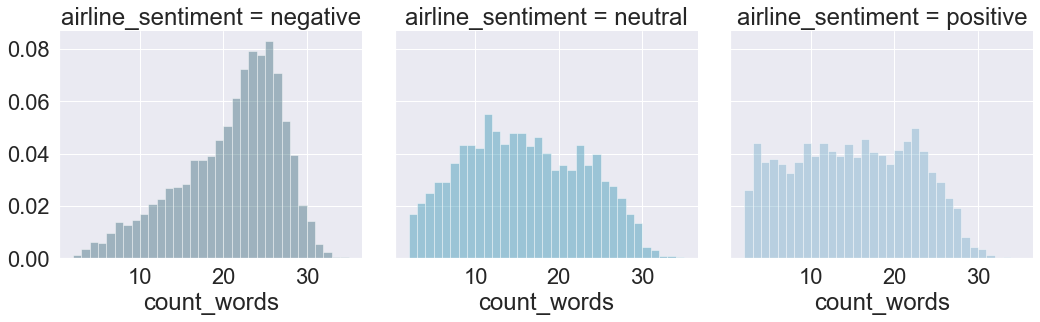

In [18]:
show_dist(df_eda ,'count_words')
#show_dist(df_eda , 'count_emojis')
#show_dist(df_eda , 'count_mentions')
#show_dist(df_eda , 'count_capital_words')
#show_dist(df_eda , 'count_excl_quest_marks')
#show_dist(df_eda , 'count_urls')
#show_dist(df_eda , 'count_hashtags')

In [19]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')
        # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X


In [20]:
ct = CleanText()
sr_clean = ct.fit_transform(df.text)
sr_clean.head(5)


5318     love guy even comcast better phone help system simpl callback system would fix problem
3272     finger cross capabl get baggag point gt unit airlin                                   
12811    um no hang what’ new                                                                  
13313    thank cc                                                                              
6992     lol fleet fleek                                                                       
Name: text, dtype: object

In [21]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'


22 records have no words left after text cleaning


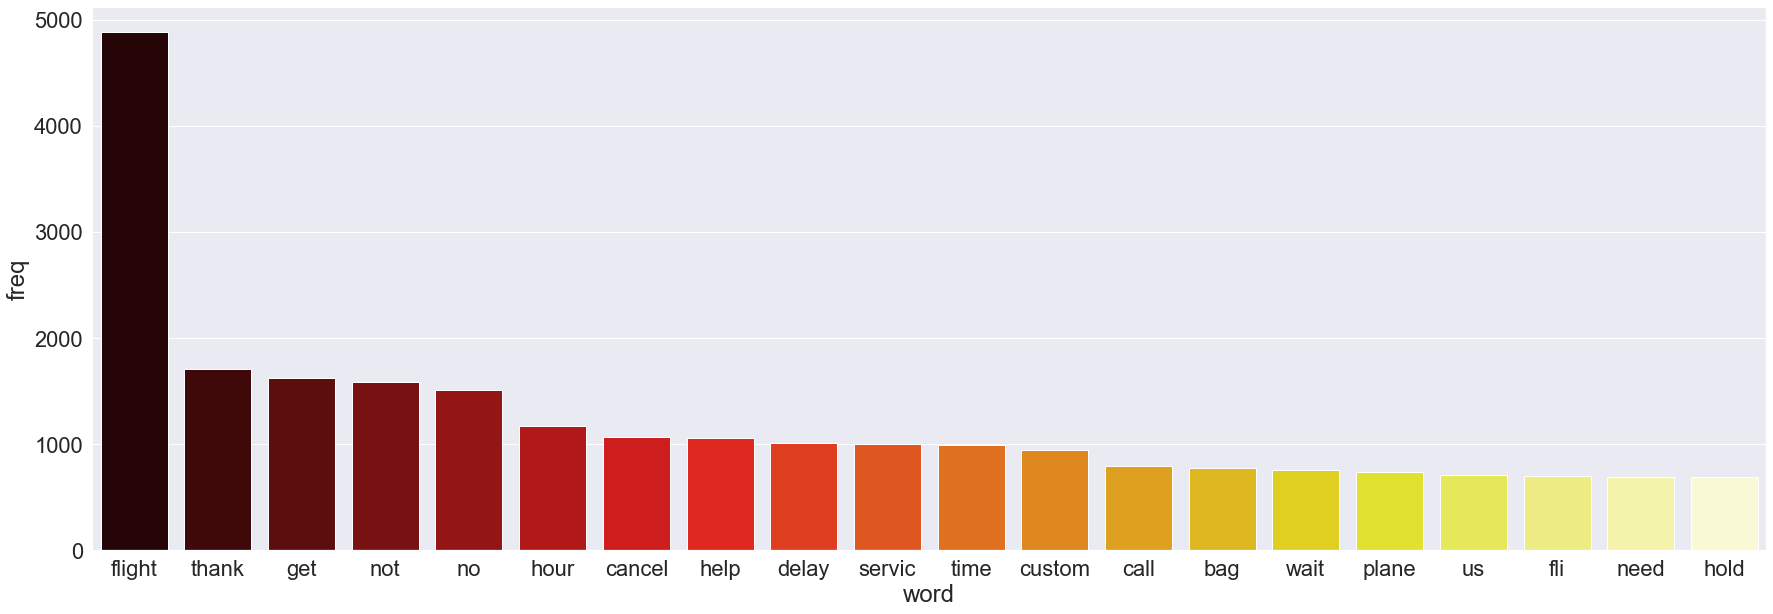

In [22]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(30, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="hot", ax=ax)
plt.show();

In [23]:
df_model = df_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()


['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'airline_sentiment',
 'clean_text']

In [24]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('airline_sentiment', axis=1),
                                    df_model.airline_sentiment, test_size=0.1, random_state=37)


In [25]:
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']   
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)  
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)
    
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    
    grid_search.fit(X_train, y_train)
    
    best_parameters = grid_search.best_estimator_.get_params()
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))                  
    return grid_search

In [26]:
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

In [27]:
logreg = LogisticRegression()

In [28]:
countvect = CountVectorizer()
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, 
                                  parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.6min finished


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.83      0.90      0.87       926
     neutral       0.63      0.54      0.58       308
    positive       0.77      0.67      0.71       230

    accuracy                           0.79      1464
   macro avg       0.74      0.70      0.72      1464
weighted avg       0.78      0.79      0.78      1464



In [31]:
textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
,'count_mentions','count_urls','count_words']
features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
, ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))
, ('vect', CountVectorizer(max_df=0.5, min_df=1, ngram_range=(1,2)))]))], n_jobs=-1)
pipeline = Pipeline([('features', features), ('clf', LogisticRegression(C=1.0, penalty='l2'))])
best_model = pipeline.fit(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment)
new_tweets = pd.Series(['How are doing all? Why did i not hear from you all ' ,'something is very exciting',
                        "Ryne has become a model for our story images and so apparently grew a moustache which I didn't think he was capable of. Naturallr, I'm loving it." ,
                        'Good for a laugh i heard about this book' ])
df_counts_pos = tc.transform(new_tweets)
df_clean_pos = ct.transform(new_tweets)
df_model_pos = df_counts_pos
df_model_pos['clean_text'] = df_clean_pos
print(best_model.predict(df_model_pos).tolist())


['negative', 'neutral', 'negative', 'positive']
